In [1]:
%load_ext autoreload
%autoreload 2
from vip_helpers import *
import matplotlib.pyplot as plt
import os
from utils.getDataFiles import *
from lfp.readLFP import *
from lfp.lfpFunctions import *

main_path = '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left'
rec_paths = [os.path.join(main_path, rec_path) for rec_path in os.listdir(main_path) if not rec_path.endswith('stim') and rec_path.startswith('p')]
rec_paths = get_recording_paths_sorted(main_path)
dataclasses, state_dfs, s2p_outs, recording_days = load_animal_data('Front_left')
s2p_dict = dict(zip(recording_days, s2p_outs))
dataclasses_dict = dict(zip(recording_days, dataclasses))
state_dfs_dict = dict(zip(recording_days, state_dfs))
animal_spikes = {rec_day:s2p_out.get_cell_spikes() for rec_day, s2p_out in s2p_dict.items()}
animal_f_traces = {rec_day:s2p_out.calc_deltaF()[0] for rec_day, s2p_out in s2p_dict.items()}
recs_10_15 = [path for path in rec_paths if os.path.basename(path) in ['p10', 'p15']]
recs_10_15

/home/gianna/anaconda3/envs/vip_venv/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
/home/gianna/Desktop/PythonProjects/VIPxTigerAnalyses/twop/getSuite2POutput.py:117: RuntimeWarning: invalid value encountered in divide
  deltaF = (rawF - baseline) / baseline


['/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p10',
 '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p15']

In [ ]:
from intan.readIntan import *

data, fs_analog, convertUnitsVolt, intan_header = get_intan_data('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p12',
                                                                 plot_intan=True)

plot_raw_intan(data, start_s=300, end_s=302)

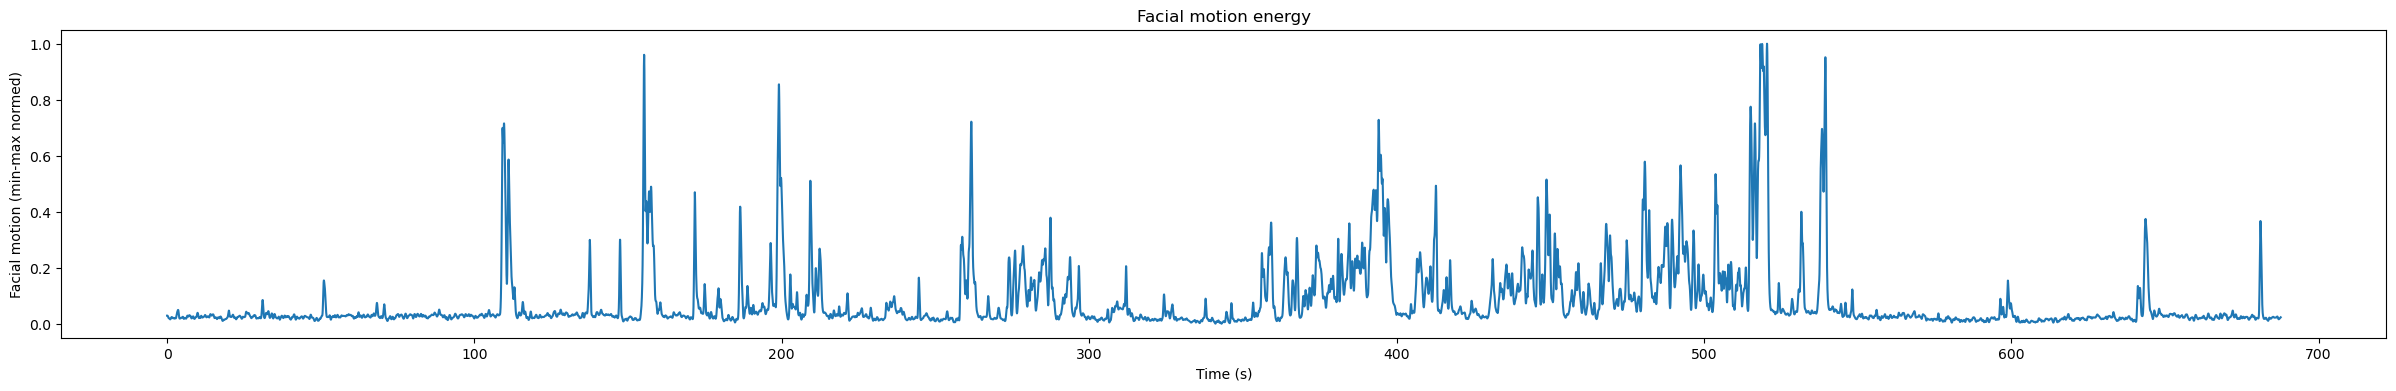

In [21]:
p12_motion = state_dfs_dict['p12']['motion']
plt.figure(figsize=(30,4))
plt.plot(np.arange(len(p12_motion)) / 30, p12_motion)
plt.xlabel('Time (s)')
plt.ylabel('Facial motion (min-max normed)')
plt.title('Facial motion energy')
plt.show()

In [ ]:
from hmm_help import *
recording = '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p12'
p12_lfp = load_lfp(os.path.join(recording, f'{os.path.basename(recording)}.lfp'))
freqs_+, times, power_db = compute_power_spect_db(p12_lfp[0], fs=1250)
bandpowers_chan0 = summarize_bands(power_db, freqs)
delta, theta, gamma = bandpowers['delta_z'], bandpowers['theta_z'], bandpowers['gamma_z']
gamma

array([-1.42055752, -2.28238422, -2.13759519, ...,  0.98102541,
        0.10204441,  0.07515842], shape=(1695,))

In [ ]:
# state_dfs_dict = {day:dataclass.make_state_df(
#                                               paw_data=True,
#                                               motion_indices={'motion':1, 'right_paw':1, 'left_paw':2})
#                                               for day, dataclass in dataclasses_dict.items()}
state_dfs_dict = {}
#state_dfs_dict['p17']
for day, dataclass in dataclasses_dict.items():
    try:
        print(f"Getting data for {day}")
        rec_state_df = dataclass.make_state_df(paw_data=True,
                                                motion_indices={'motion':1, 'right_paw':1, 'left_paw':2})
        state_dfs_dict[day] = rec_state_df
        rec_state_df.to_parquet(os.path.join(dataclass.intan_basepath, f'{day}_state_df.parquet'), engine=('pyarrow'))
    except:
        traceback.print_exc()
        print(f'Failed creation of state df for ')    
state_dfs_dict

In [ ]:

def plot_per_chan_band_hist(rec_paths, band_type, lfp_channels=[1, 0],
                             lfp_chan_titles= ['Channel 1 (local V1)', 'Channel 2'],
                               color="#0B5E24", lfp_fs=1250, ylab='Power dB', suptitle='Gamma Power'):
    fig, axs = plt.subplots(len(lfp_channels), 1, figsize=(50,20))
    rec_idx = 0
    for rec in rec_paths:
        day = os.path.basename(rec)
        rec_lfp = os.path.join(rec, f'{day}.lfp')
        lfp = load_lfp(rec_lfp)
        lfp_chan_idx = 0
        for lfp_chan_idx, lfp_chan in enumerate(lfp_channels):
            freqs, times, power_db = compute_power_spect_db(lfp[lfp_chan], fs=lfp_fs)
            bandpowers = summarize_bands(power_db, f=freqs)
            if band_type == 'delta_theta_ratio':
                band_signal = zscore(bandpowers['delta']/bandpowers['theta'])
            elif band_type == 'delta_beta_ratio':
                band_signal = zscore(bandpowers['delta']/bandpowers['beta'])
            elif band_type == 'theta_gamma_ratio':
                band_signal = zscore(bandpowers['theta']/bandpowers['gamma'])
            else:
                band_signal = zscore(bandpowers[band_type])
            axs[lfp_chan_idx].plot(np.arange(len(band_signal)), band_signal, label=f'{day}', color=color)
            axs[lfp_chan_idx].set_title(lfp_chan_titles[lfp_chan_idx])
            axs.legend()
            axs.set_ylabel(ylab)
        rec_idx += 1
    plt.suptitle(suptitle)
    plt.show()
    return

plot_per_chan_band_hist(rec_paths, band_type='delta', suptitle='Delta Power', color="#CE19E6")



In [6]:
day1_ex = '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p9'
rec_lfp = os.path.join(day1_ex, f'{os.path.basename(day1_ex)}.lfp')
lfp_ex = load_lfp(rec_lfp)
freqs_v1, times_v1, power_db_v1 = compute_power_spect_db(lfp_ex[0], fs=1250)
freqs_s1, times_s1, power_db_s1 = compute_power_spect_db(lfp_ex[1], fs=1250)
bandpowers = summarize_bands(power_db_v1, f=freqs_v1)
metrics_v1 = overall_metrics(power_db_v1, f=freqs_v1)

In [ ]:
fig, axs = plt.subplots(9, 2, figsize=(50,20))
colors = ["#A4D3EE", "#57B2E7", "#007AC0", 
          "#085BA0", "#0D5D9E", "#0B817B",
          "#03485E", "#093341", "#0C0753"]
rec_idx = 0
for rec in rec_paths:
    day = os.path.basename(rec)
    rec_lfp = os.path.join(rec, f'{day}.lfp')
    lfp = load_lfp(rec_lfp)

    freqs_v1, times_v1, power_db_v1 = compute_power_spect_db(lfp[1], fs=1250)
    bandpowers = summarize_bands(power_db_v1, f=freqs_v1)

    freqs_s1, times_s1, power_db_s1 = compute_power_spect_db(lfp[0], fs=1250)
    bandpowers_s1 = summarize_bands(power_db_s1, f=freqs_s1)
    delta_theta_v1, delta_theta_s1 = zscore(bandpowers['delta']/bandpowers['theta']), zscore(bandpowers_s1['delta']/bandpowers_s1['theta'])
    axs[rec_idx, 0].plot(np.arange(len(delta_theta_v1)), delta_theta_v1, label=f'{day}', color=colors[rec_idx])
    axs[rec_idx, 0].set_title(f'{day}, channel 1 (local V1)')
    axs[rec_idx, 1].plot(np.arange(len(delta_theta_s1)) , delta_theta_s1, label=f'{day}', color=colors[rec_idx])
    axs[rec_idx, 1].set_title(f'{day}, channel 2')
    rec_idx += 1
plt.suptitle('Delta/Theta Ratio', y=0.96)
plt.subplots_adjust(hspace=1)
plt.show()

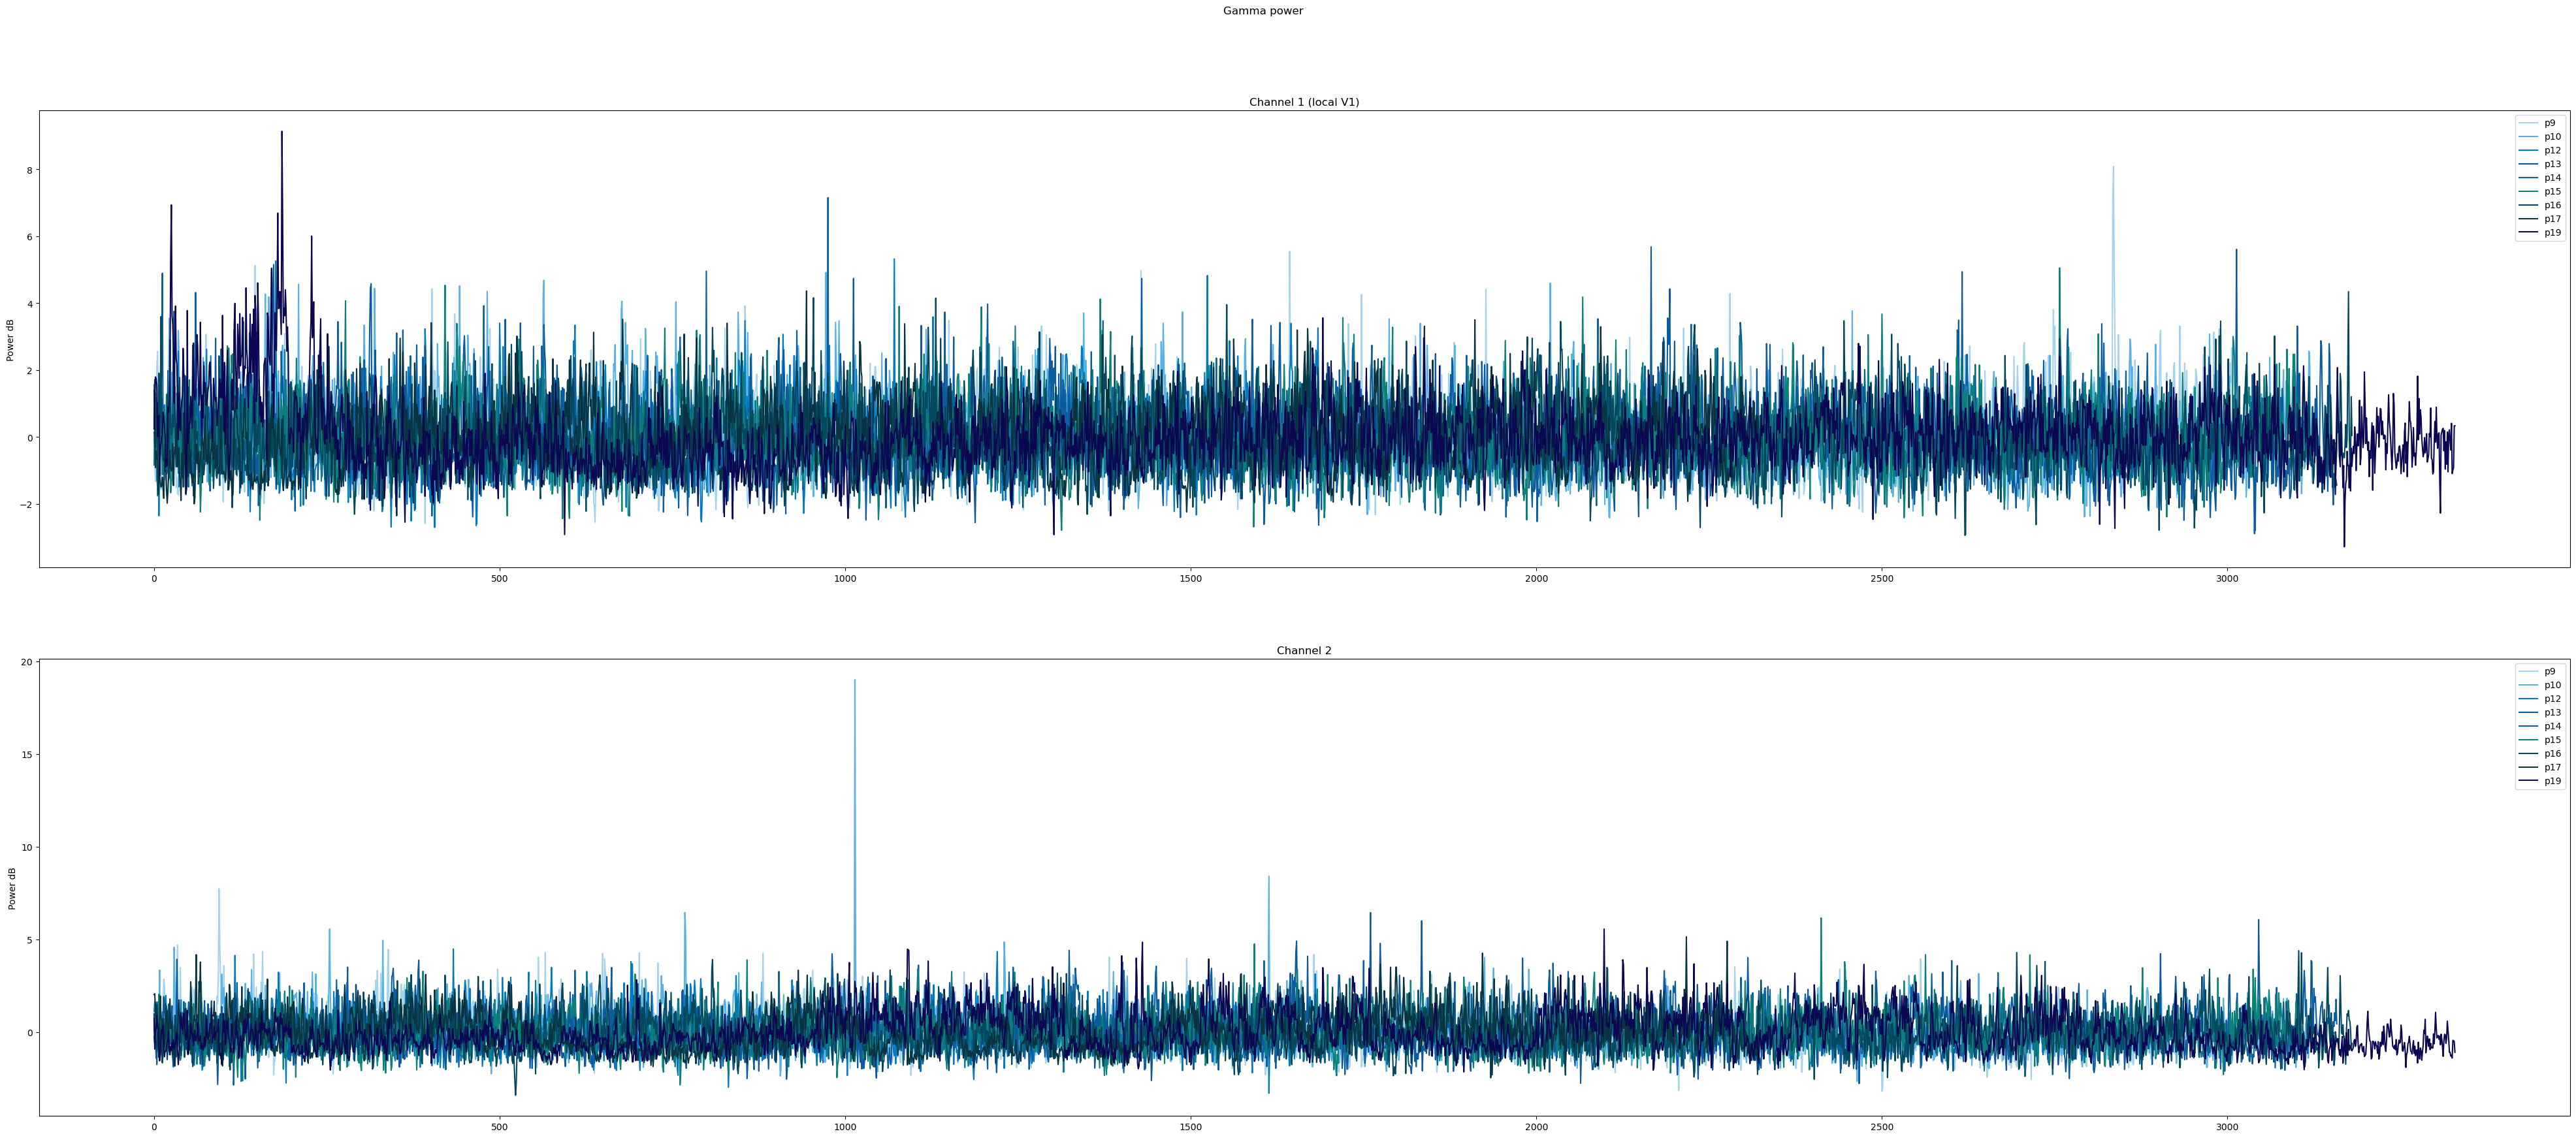

In [ ]:
from scipy.stats import zscore

fig, axs = plt.subplots(2, 1, figsize=(50,20))
colors = ["#A4D3EE", "#57B2E7", "#007AC0", 
          "#085BA0", "#0D5D9E", "#0B817B",
          "#03485E", "#093341", "#0C0753"]
rec_idx = 0
for rec in rec_paths:
    day = os.path.basename(rec)
    rec_lfp = os.path.join(rec, f'{day}.lfp')
    lfp = load_lfp(rec_lfp)

    freqs_v1, times_v1, power_db_v1 = compute_power_spect_db(lfp[1], fs=1250)
    bandpowers = summarize_bands(power_db_v1, f=freqs_v1)

    freqs_s1, times_s1, power_db_s1 = compute_power_spect_db(lfp[0], fs=1250)
    bandpowers_s1 = summarize_bands(power_db_s1, f=freqs_s1)
    gamma_v1, gamma_s1 = bandpowers['gamma_z'], bandpowers_s1['gamma_z']
    delta_theta_v1, delta_theta_s1 = zscore(bandpowers['delta']/bandpowers['theta']), zscore(bandpowers_s1['delta']/bandpowers_s1['theta'])
    gamma_range = np.arange(30, 80)
    axs[0].plot(np.arange(len(delta_theta_v1)), delta_theta_v1, label=f'{day}', color=colors[rec_idx])
    axs[0].set_title('Channel 1 (local V1)')
    axs[1].plot(np.arange(len(delta_theta_s1)) , delta_theta_s1, label=f'{day}', color=colors[rec_idx])
    axs[0].legend()
    axs[0].set_ylabel('Power dB')
    axs[1].set_title('Channel 2')
    axs[1].legend()
    axs[1].set_ylabel('Power dB')
    rec_idx += 1
plt.suptitle('Gamma power', y=0.96)

plt.show()

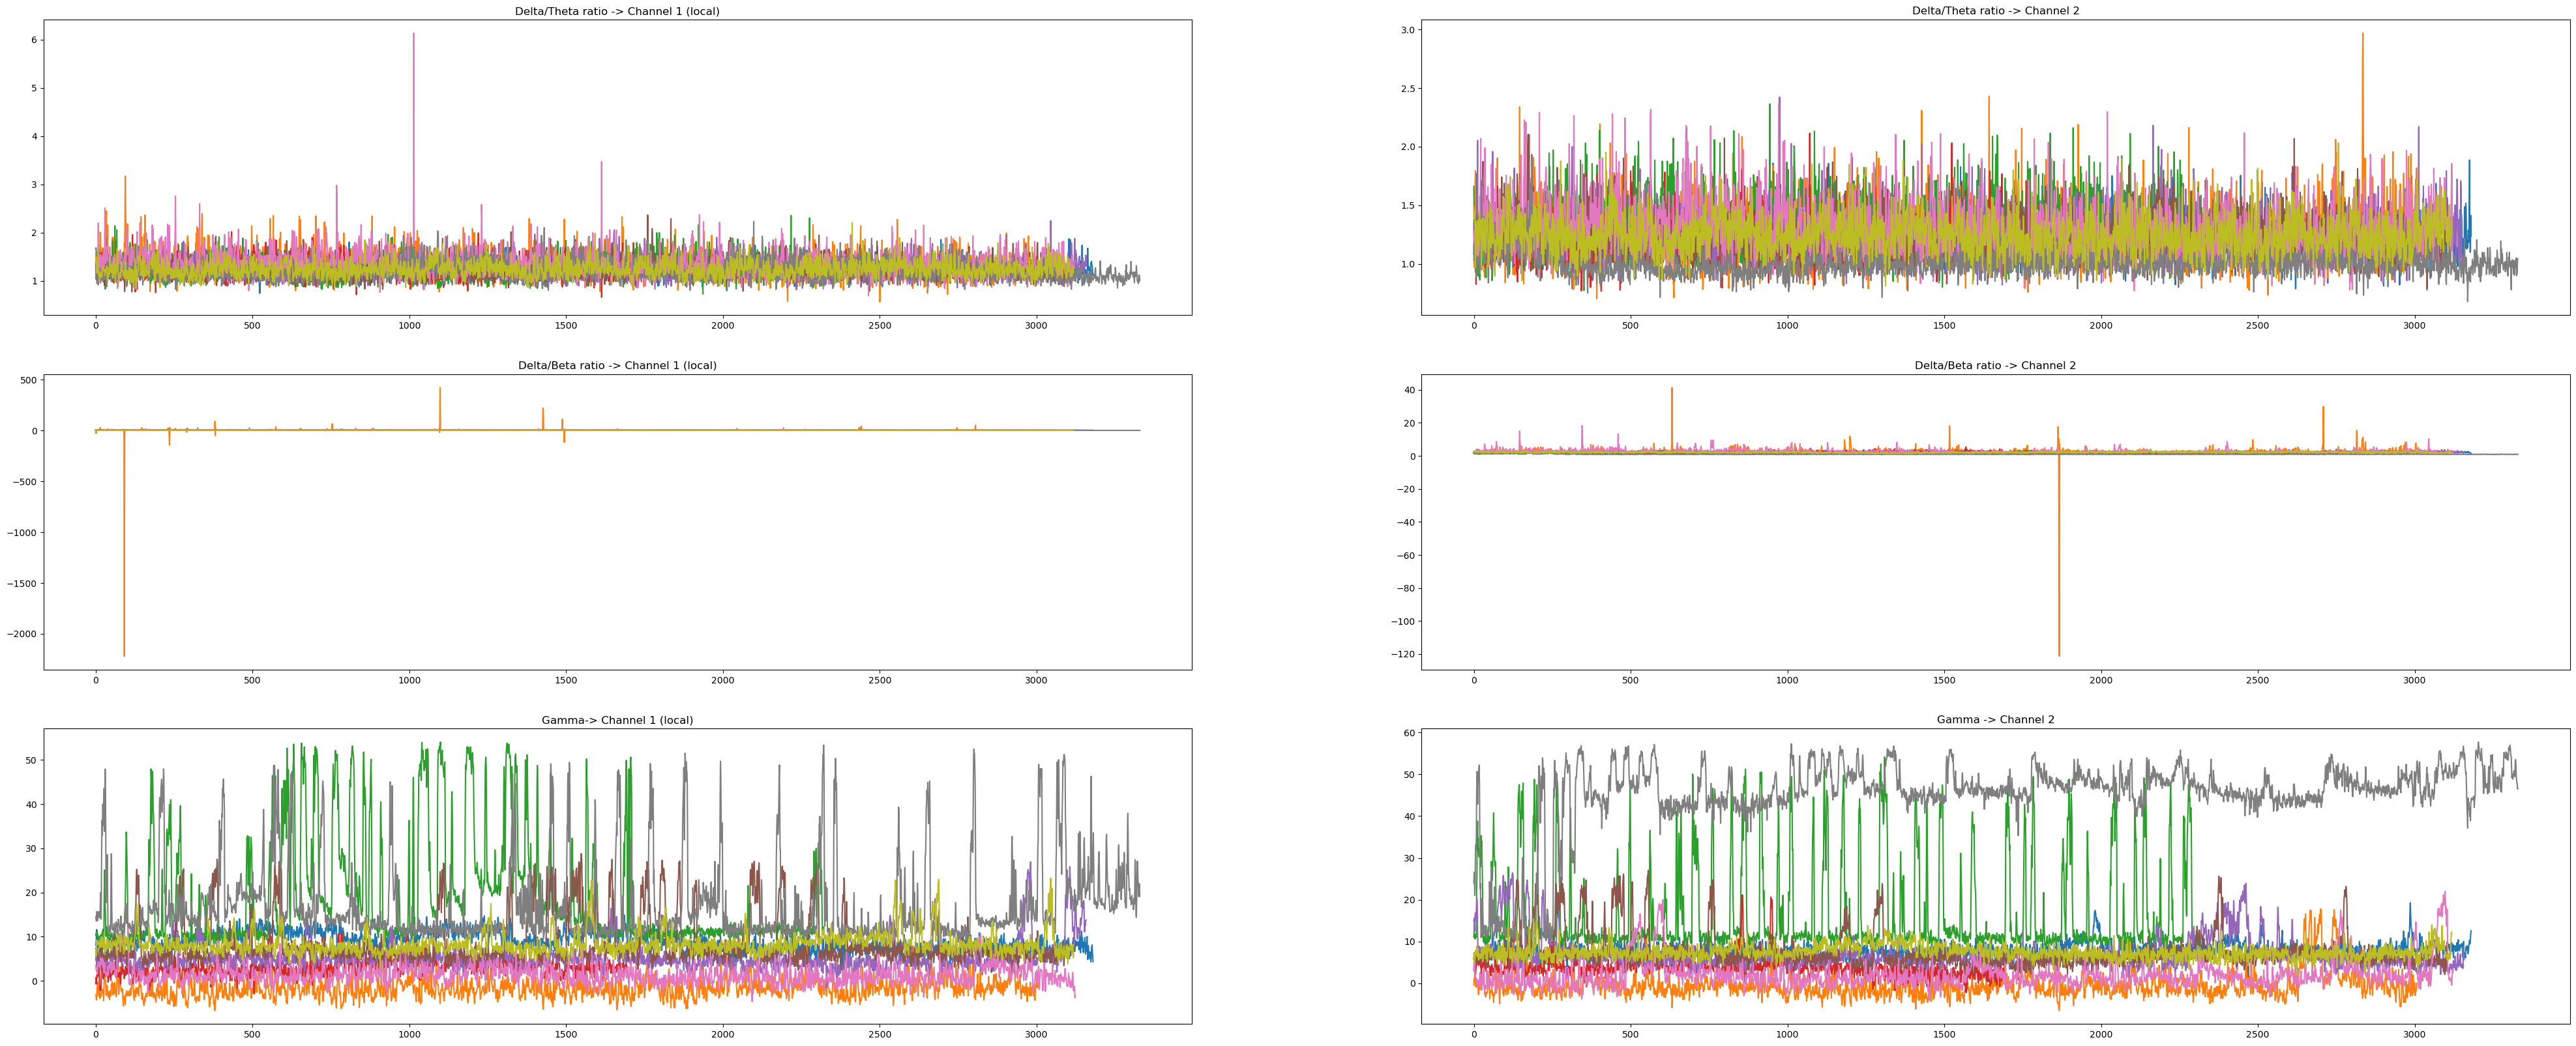

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(50,20))
#rec_idx = 0
for rec in rec_paths:
    day = os.path.basename(rec)
    rec_lfp = os.path.join(rec, f'{day}.lfp')
    lfp = load_lfp(rec_lfp)

    freqs_v1, times_v1, power_db_v1 = compute_power_spect_db(lfp[0], fs=1250)
    bandpowers = summarize_bands(power_db_v1, f=freqs_v1)
    metrics_v1 = overall_metrics(power_db_v1, f=freqs_v1)
    delta_v1, theta_v1, beta_v1, gamma_v1 = bandpowers['delta'], bandpowers['theta'], bandpowers['beta'], bandpowers['gamma']
    delta_theta_ratio_v1 = delta_v1/theta_v1
    delta_beta_ratio_v1 = delta_v1/beta_v1

    freqs_s1, times_s1, power_db_s1 = compute_power_spect_db(lfp[1], fs=1250)
    bandpowers_s1 = summarize_bands(power_db_s1, f=freqs_s1)
    metrics_s1 = overall_metrics(power_db_s1, f=freqs_s1)
    delta_s1, theta_s1, beta_s1, gamma_s1 = bandpowers_s1['delta'], bandpowers_s1['theta'], bandpowers_s1['beta'], bandpowers_s1['gamma']
    delta_theta_ratio_s1 = delta_s1/theta_s1
    delta_beta_ratio_s1 = delta_s1/beta_s1
    axs[0, 0].plot(np.arange(len(delta_theta_ratio_v1)), delta_theta_ratio_v1)
    axs[0, 0].set_title('Delta/Theta ratio -> Channel 1 (local)')
    axs[0, 1].plot(np.arange(len(delta_theta_ratio_s1)), delta_theta_ratio_s1)
    axs[0, 1].set_title('Delta/Theta ratio -> Channel 2')

    axs[1, 0].plot(np.arange(len(delta_beta_ratio_v1)), delta_beta_ratio_v1)
    axs[1, 0].set_title('Delta/Beta ratio -> Channel 1 (local)')
    axs[1, 1].plot(np.arange(len(delta_beta_ratio_s1)), delta_beta_ratio_s1)
    axs[1, 1].set_title('Delta/Beta ratio -> Channel 2')    

    axs[2, 0].plot(np.arange(len(gamma_v1)), gamma_v1)
    axs[2, 0].set_title('Gamma-> Channel 1 (local)')
    axs[2, 1].plot(np.arange(len(gamma_s1)), gamma_s1)
    axs[2, 1].set_title('Gamma -> Channel 2')
    #rec_idx += 1
plt.show()

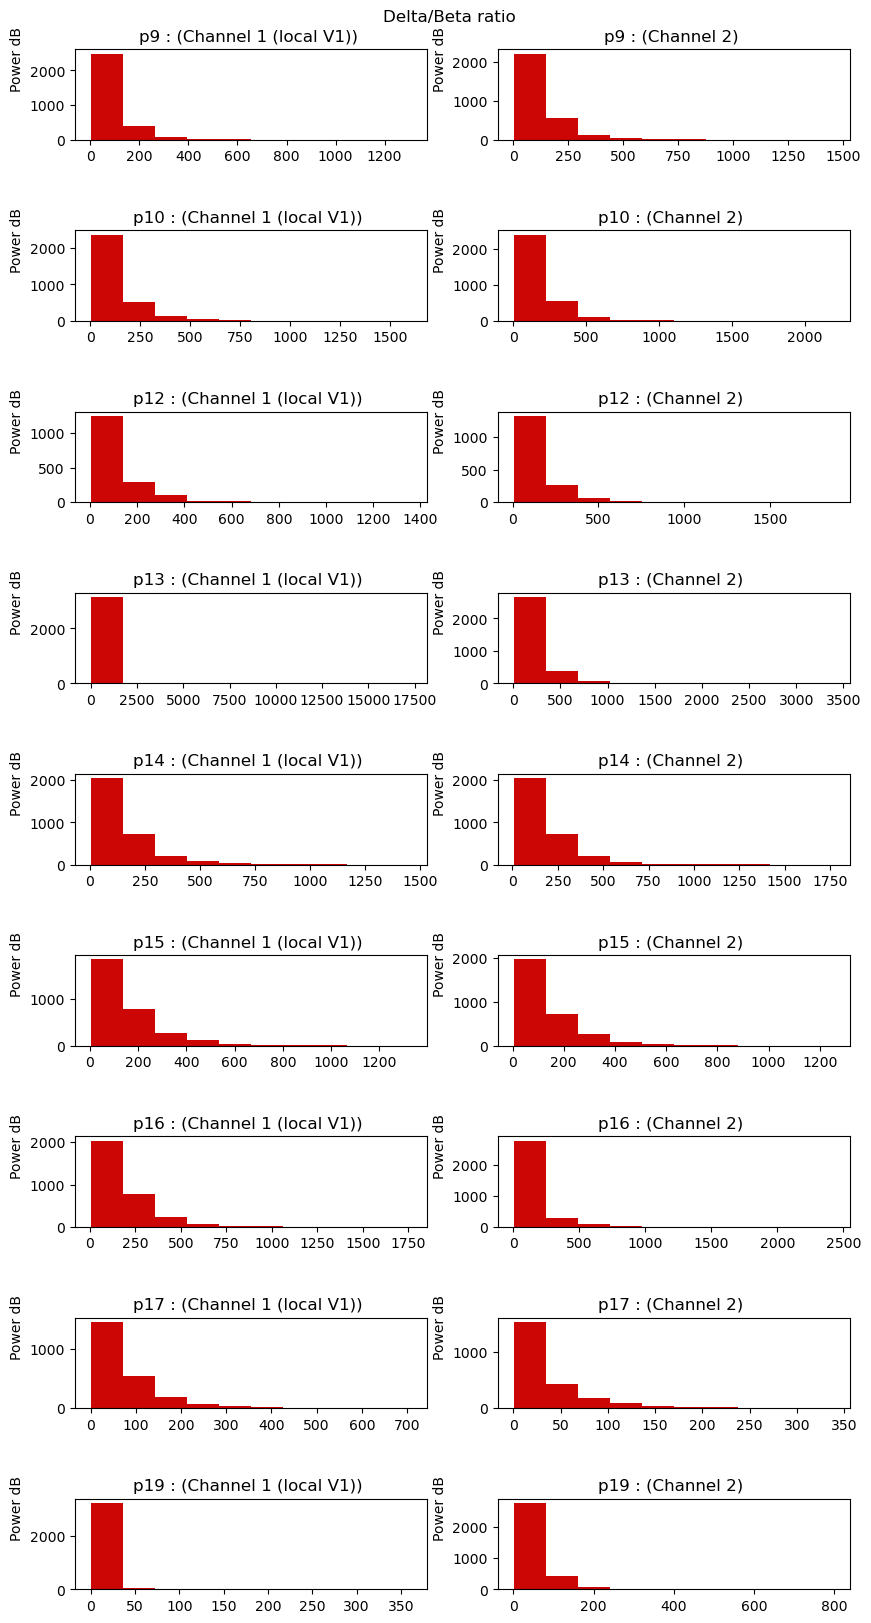

In [ ]:
from lfp.lfpFunctions import *

def plot_per_chan_band_hist(rec_paths, band_type, lfp_channels=[1, 0],
                             lfp_chan_titles= ['(Channel 1 (local V1))', '(Channel 2)'],
                               color="#0B5E24", lfp_fs=1250, ylab='Power dB', suptitle='Gamma Power'):
    fig, axs = plt.subplots(len(rec_paths), len(lfp_channels), figsize=(10,20))
    rec_idx = 0
    for rec in rec_paths:
        day = os.path.basename(rec)
        rec_lfp = os.path.join(rec, f'{day}.lfp')
        lfp = load_lfp(rec_lfp)
        lfp_chan_idx = 0
        for lfp_chan_idx, lfp_chan in enumerate(lfp_channels):
            freqs, times, power_db = compute_power_spect_db(lfp[lfp_chan], fs=lfp_fs)
            bandpowers = summarize_bands(power_db, f=freqs)
            if band_type == 'theta_delta_ratio':
                band_signal = compute_linear_power_ratio(bandpowers['theta'],bandpowers['delta'])
            elif band_type == 'delta_beta_ratio':
                band_signal = compute_linear_power_ratio(bandpowers['delta'],bandpowers['beta'])
            elif band_type == 'theta_gamma_ratio':
                band_signal = compute_linear_power_ratio(bandpowers['theta'],bandpowers['gamma'])
            else:
                band_signal = zscore(bandpowers[band_type])
            axs[rec_idx, lfp_chan_idx].hist(band_signal, label=f'{day}', color=color)
            axs[rec_idx, lfp_chan_idx].set_title(f'{day} : {lfp_chan_titles[lfp_chan_idx]} ')
            #axs.legend()
            axs[rec_idx, lfp_chan_idx].set_ylabel(ylab, y=0.9)
            #axs[rec_idx, lfp_chan_idx].set_xlim(0, 5)
        rec_idx += 1
    plt.suptitle(suptitle, y=0.9)
    plt.subplots_adjust(hspace=1)
    plt.show()
    return

#plot_per_chan_band_hist(rec_paths, band_type='theta_delta_ratio', suptitle= 'Theta/delta ratio', color="#632D8F")
plot_per_chan_band_hist(rec_paths, band_type='delta_beta_ratio', suptitle= 'Delta/Beta ratio', color="#CC0505")


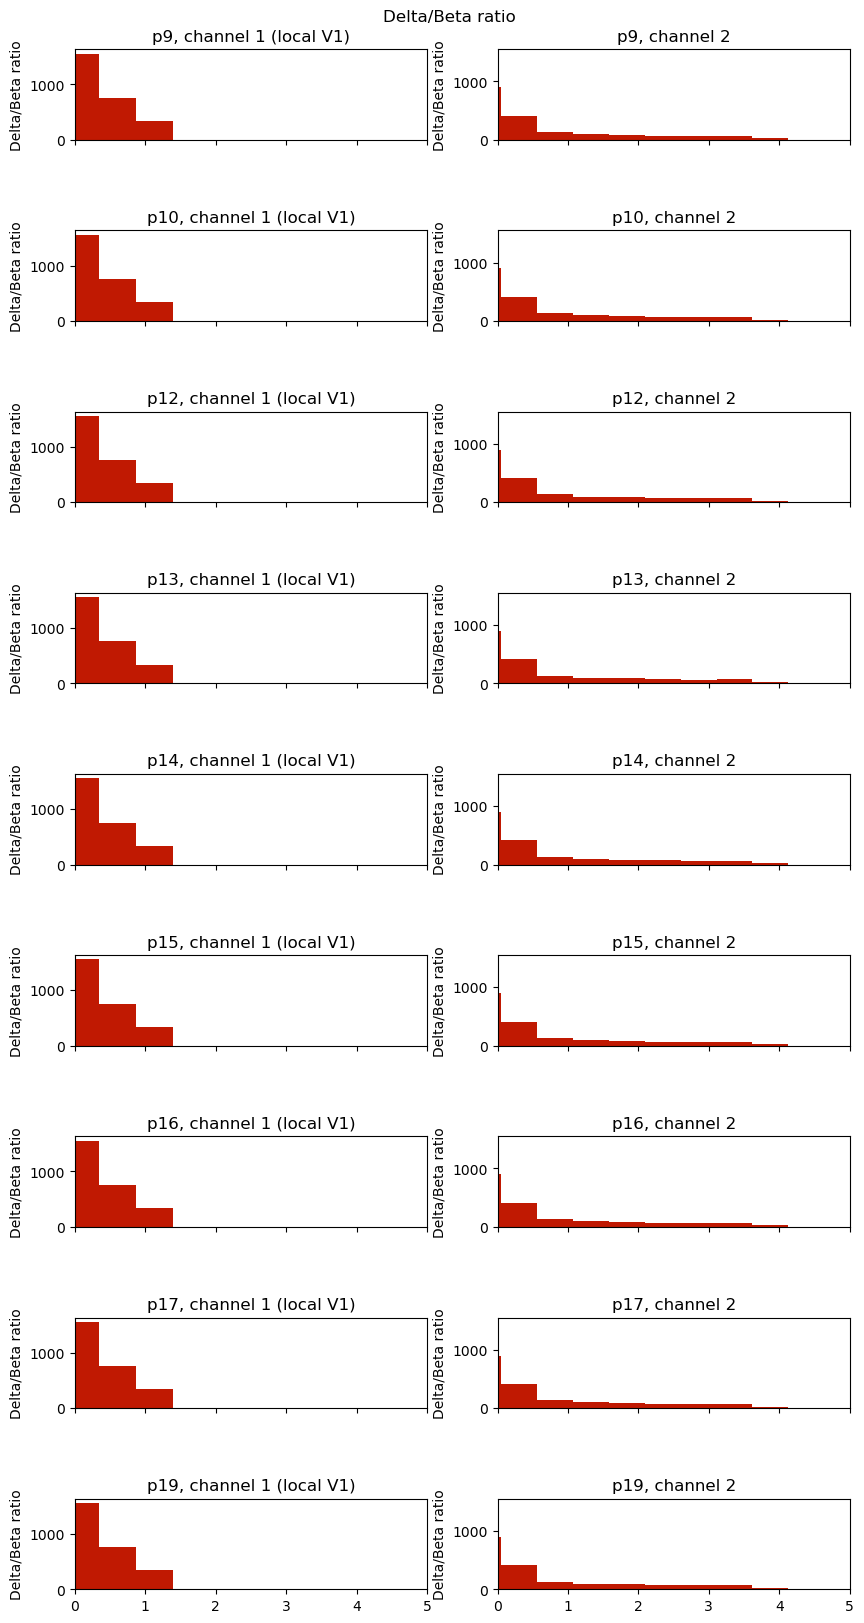

In [128]:
fig, axs = plt.subplots(9, 2, figsize=(10,20), sharex=True)
colors = ["#A4D3EE", "#57B2E7", "#007AC0", 
          "#085BA0", "#0D5D9E", "#0B817B",
          "#03485E", "#093341", "#0C0753"]
rec_idx = 0
for rec in rec_paths:
    day = os.path.basename(rec)
    rec_lfp = os.path.join(rec, f'{day}.lfp')
    lfp = load_lfp(rec_lfp)

    freqs_v1, times_v1, power_db_v1 = compute_power_spect_db(lfp[1], fs=1250)
    bandpowers = summarize_bands(power_db_v1, f=freqs_v1)

    freqs_s1, times_s1, power_db_s1 = compute_power_spect_db(lfp[0], fs=1250)
    bandpowers_s1 = summarize_bands(power_db_s1, f=freqs_s1)
    #delta_theta_v1, delta_theta_s1 = zscore(bandpowers['delta']/bandpowers['theta']), zscore(bandpowers_s1['delta']/bandpowers_s1['theta'])
    delta_beta_v1, delta_beta_s1 = zscore(bandpowers['delta']/bandpowers['beta']), zscore(bandpowers_s1['delta']/bandpowers_s1['beta'])
    from scipy.stats import zscore
    #gamma_v1, gamma_s1 = zscore(bandpowers['gamma']), zscore(bandpowers_s1['gamma'])

    axs[rec_idx, 0].hist(gamma_v1, color="#C01902") #color="#4B07B9"
    axs[rec_idx, 0].set_xlim(0, 5)
    #axs[rec_idx, 0].set_ylabel('Gamma power dB')
    axs[rec_idx, 0].set_ylabel('Delta/Beta ratio')
    axs[rec_idx, 1].hist(gamma_s1, color="#C01902")
    #axs[rec_idx, 1].hist(delta_theta_s1, color='#4B07B9')
    axs[rec_idx, 0].set_title(f'{day}, channel 1 (local V1)')
    #axs[rec_idx, 1].set_ylabel('Delta/Beta ratio')
    axs[rec_idx, 1].set_ylabel('Delta/Beta ratio')
    # axs[rec_idx, 1].plot(np.arange(len(delta_theta_s1)) , delta_theta_s1, label=f'{day}', color=colors[rec_idx])
    axs[rec_idx, 1].set_title(f'{day}, channel 2')
    rec_idx += 1
#plt.suptitle('Normalized delta/theta ratio', y=0.9)
plt.suptitle('Delta/Beta ratio', y=0.9)
plt.subplots_adjust(hspace=1)
plt.show()

In [2]:
rec_paths
recs_10_15 = [path for path in rec_paths if os.path.basename(path) in ['p10', 'p15']]
recs_10_15

['/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p10',
 '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p15']

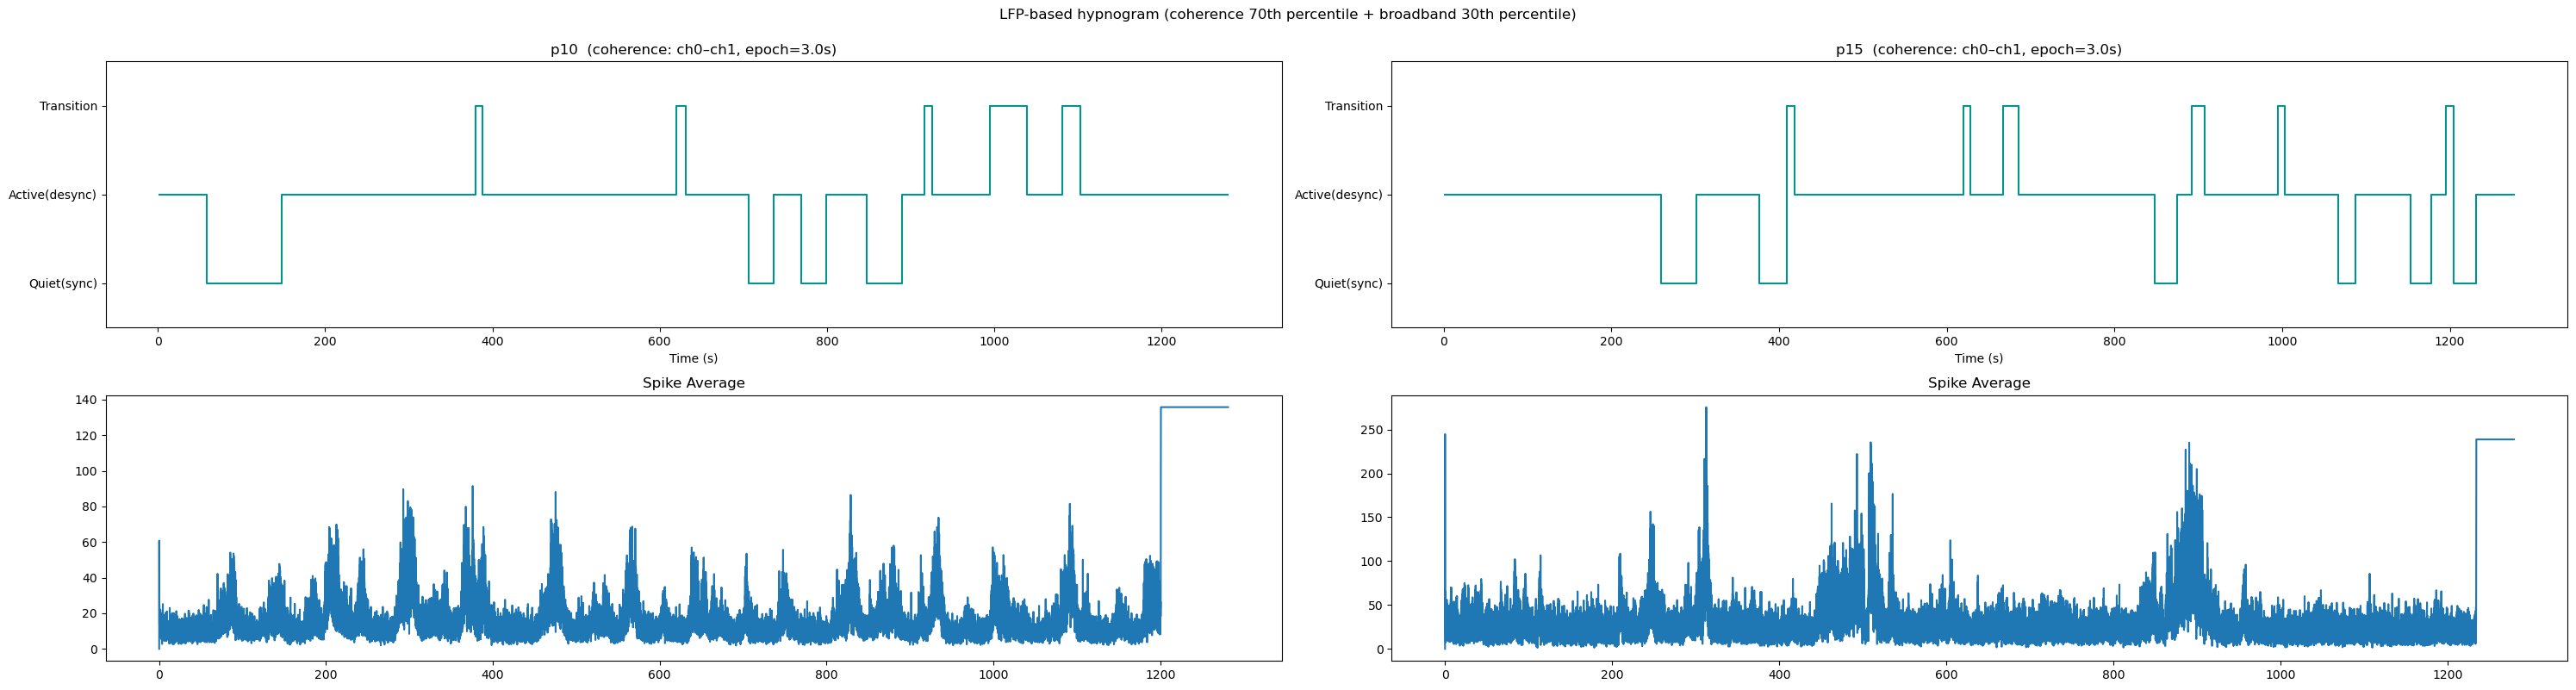

{'p10': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def compute_band_coherence_timeseries(
    x, y, fs,
    epoch_s=3.0,
    bands=((1.0, 4.0), (6.0, 10.0)),  # delta, theta (adjust as you like)
    nperseg_s=2.0
):
    """
    Sliding, non-overlapping epoch coherence in specified bands.

    Returns:
        t_epoch : (n_epochs,) epoch center times (s)
        coh_bands : (n_epochs, n_bands) mean coherence in each band
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = min(len(x), len(y))
    x = x[:n]
    y = y[:n]

    epoch_n = int(round(epoch_s * fs))
    if epoch_n < 4:
        raise ValueError("epoch_s too small for coherence estimation.")

    n_epochs = n // epoch_n 
    if n_epochs <= 0:
        return np.array([]), np.zeros((0, len(bands)))

    # coherence params within each epoch
    nperseg = int(round(nperseg_s * fs))
    nperseg = max(16, min(nperseg, epoch_n))  # clamp
    noverlap = nperseg // 2

    coh_bands = np.zeros((n_epochs, len(bands)), dtype=float)
    t_epoch = np.zeros(n_epochs, dtype=float)

    for i in range(n_epochs):
        s0 = i * epoch_n
        s1 = s0 + epoch_n
        xe = x[s0:s1]
        ye = y[s0:s1]

        f, cxy = coherence(xe, ye, fs=fs, nperseg=nperseg, noverlap=noverlap)

        for b_idx, (f_lo, f_hi) in enumerate(bands):
            m = (f >= f_lo) & (f <= f_hi)
            coh_bands[i, b_idx] = np.nanmean(cxy[m]) if np.any(m) else np.nan

        t_epoch[i] = (s0 + s1) / 2.0 / fs

    return t_epoch, coh_bands

def interp_to_epochs(t_src, x_src, t_epochs):
    """Interpolate feature defined on t_src onto t_epochs."""
    t_src = np.asarray(t_src)
    x_src = np.asarray(x_src)
    t_epochs = np.asarray(t_epochs)

    good = np.isfinite(t_src) & np.isfinite(x_src)
    if np.sum(good) < 2:
        return np.full_like(t_epochs, np.nan, dtype=float)

    return np.interp(t_epochs, t_src[good], x_src[good])

def resample_motion_to_lfp(motion, motion_fs, lfp_fs, n_lfp_samples):
    t_motion = np.arange(len(motion)) / motion_fs
    t_lfp    = np.arange(n_lfp_samples) / lfp_fs

    # interpolate motion onto LFP time grid
    motion_resampled = np.interp(t_lfp, t_motion, motion)

    return t_lfp, motion_resampled

def make_states_dict_coherence(
    rec_paths,
    lfp_channels,
    lfp_fs,
    epoch_s=3.0,
    min_bout_s=3.0,
    sync_thresh=70,
    broadband_thresh = 30,
    title=None

):
    """
    Coherence-based state classification using BOTH channels:
      sync feature = log10(delta_coh/theta_coh)
      broadband feature = mean(broadband_z across channels)

    Returns:
        states_dict[day] = state_clean  (0 Quiet/sync, 1 Active/desync, 2 Transition)
    """
    if len(lfp_channels) != 2:
        raise ValueError("This coherence-based version expects exactly 2 lfp_channels.")

    fig, axs = plt.subplots(2, len(rec_paths), figsize=(30, 4 * len(rec_paths)))
    if len(rec_paths) == 1:
        axs = [axs]

    states_dict = {}

    for rec_idx, rec in enumerate(rec_paths):
        day = os.path.basename(rec)
        state_df_day = state_dfs_dict[day]
        rec_lfp = os.path.join(rec, f"{day}.lfp")
        lfp = load_lfp(rec_lfp)
        #motion = state_df_day['motion']
        motion = np.nanmean(animal_spikes[day], axis=0)
        ch0, ch1 = lfp_channels
        x = lfp[ch0]
        y = lfp[ch1]

        # --------- Broadband power (per-channel) from your spectrogram pipeline ----------
        freqs0, times0, power_db0 = compute_power_spect_db(x, fs=lfp_fs)
        freqs1, times1, power_db1 = compute_power_spect_db(y, fs=lfp_fs)

        bp0 = summarize_bands(spect_power_db=power_db0, f=freqs0)
        bp1 = summarize_bands(spect_power_db=power_db1, f=freqs1)

        # broadband z per time-bin
        bb0 = np.asarray(bp0["broadband_z"])
        bb1 = np.asarray(bp1["broadband_z"])

        # Use a common time axis for broadband (assume compute_power_spect_db returns similar times)
        # If not identical, we interpolate one onto the other and average.
        times0 = np.asarray(times0)
        times1 = np.asarray(times1)
        bb1_on_0 = interp_to_epochs(times1, bb1, times0)
        bb_mean = np.nanmean(np.vstack([bb0, bb1_on_0]), axis=0)

        # --------- Delta/theta COHERENCE ratio per epoch ----------
        t_epoch, coh_bands = compute_band_coherence_timeseries(
            x, y, fs=lfp_fs, epoch_s=epoch_s,
            bands=((1.0, 4.0), (6.0, 10.0)),  # delta, theta (tweak if needed)
            nperseg_s=2.0
        )
        if len(t_epoch) == 0:
            states_dict[day] = np.array([], dtype=int)
            continue

        delta_coh = coh_bands[:, 0]
        theta_coh = coh_bands[:, 1]

        # ratio feature (log space is nicer)
        dtr_coh = (delta_coh + 1e-12) / (theta_coh + 1e-12)
        dtr_coh_log = np.log10(dtr_coh)

        # --------- Put broadband onto the SAME epoch grid ----------
        # Use epoch centers (t_epoch) and interpolate broadband (which is on spectrogram times)
        bb_epoch = interp_to_epochs(times0, bb_mean, t_epoch)
        def smooth1d(x, win=9):
                x = np.asarray(x, float)
                if win <= 1:
                    return x
                k = np.ones(win) / win
                return np.convolve(x, k, mode="same")
        # smooth features (optional; your original approach)
        dtr_coh_log_s = smooth1d(dtr_coh_log, win=9)
        bb_s          = smooth1d(bb_epoch, win=9)

        lo_sync_thresh = 100 - sync_thresh
        # thresholds (percentiles like before; tune as you like)
        hi_sync = np.nanpercentile(dtr_coh_log_s, sync_thresh)  # high delta/theta coherence ratio = "sync"
        lo_sync = np.nanpercentile(dtr_coh_log_s, lo_sync_thresh)  # low = "desync"
        hi_bb   = np.nanpercentile(bb_s, broadband_thresh)           # high broadband = active/arousal/artifact

        # states: 0=Quiet/sync, 1=Active/desync, 2=Transition
        state = np.full_like(dtr_coh_log_s, 2, dtype=int)

        # Quiet / synchronized: high coherence ratio AND low-ish broadband
        state[(dtr_coh_log_s >= hi_sync) & (bb_s < hi_bb)] = 0

        # Active / desynchronized: low coherence ratio OR broadband high
        state[(dtr_coh_log_s <= lo_sync) | (bb_s >= hi_bb)] = 1

        # enforce minimum bout duration
        state_clean = enforce_min_state_duration(state, minimum_duration=min_bout_s)

        # store & plot
        states_dict[day] = state_clean
        ax = axs[0,rec_idx]
        ax.step(t_epoch, state_clean, where="post", color="#00948D")
        ax.set_yticks([0, 1, 2], ["Quiet(sync)", "Active(desync)", "Transition"])
        ax.set_ylim(-0.5, 2.5)
        ax.set_xlabel("Time (s)")
        ax.set_title(f"{day}  (coherence: ch{ch0}–ch{ch1}, epoch={epoch_s}s)")
        motion_ax = axs[1, rec_idx]
        t_lfp, motion_resampled = resample_motion_to_lfp(motion, motion_fs=29.985, lfp_fs=1250, n_lfp_samples=len(lfp[0]))
        motion_ax.plot(t_lfp, motion_resampled)
        motion_ax.set_title("Spike Average")
    if title:
        plt.suptitle(title, y=0.995)
    plt.tight_layout()
    plt.show()

    return states_dict

from lfp.lfpFunctions import *
make_states_dict_coherence(recs_10_15, lfp_channels=[0,1], lfp_fs=1250,
                           broadband_thresh=30, sync_thresh=70,
                             title="LFP-based hypnogram (coherence 70th percentile + broadband 30th percentile)")

In [6]:
from utils.getFPS import *
day = dataclasses_dict['p10']
cam_fps = get_camera_fps(dataclasses_dict['p10'].camera_times)
cam_fps

np.float64(29.985007496316964)

In [9]:
import numpy as np

def resample_motion_to_lfp(motion, motion_fs, lfp_fs, n_lfp_samples):
    t_motion = np.arange(len(motion)) / motion_fs
    t_lfp    = np.arange(n_lfp_samples) / lfp_fs

    # interpolate motion onto LFP time grid
    motion_resampled = np.interp(t_lfp, t_motion, motion)

    return t_lfp, motion_resampled

state_df_day = state_dfs_dict['p10']
motion = state_df_day['motion']
lfp = load_lfp('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Front_left/p10/p10.lfp')
resample_motion_to_lfp(motion, motion_fs=29.985, lfp_fs=1250, n_lfp_samples=len(lfp[0]))

(array([0.0000000e+00, 8.0000000e-04, 1.6000000e-03, ..., 1.2812016e+03,
        1.2812024e+03, 1.2812032e+03], shape=(1601505,)),
 array([0.05030416, 0.05028961, 0.05027507, ..., 0.49240972, 0.49240972,
        0.49240972], shape=(1601505,)))

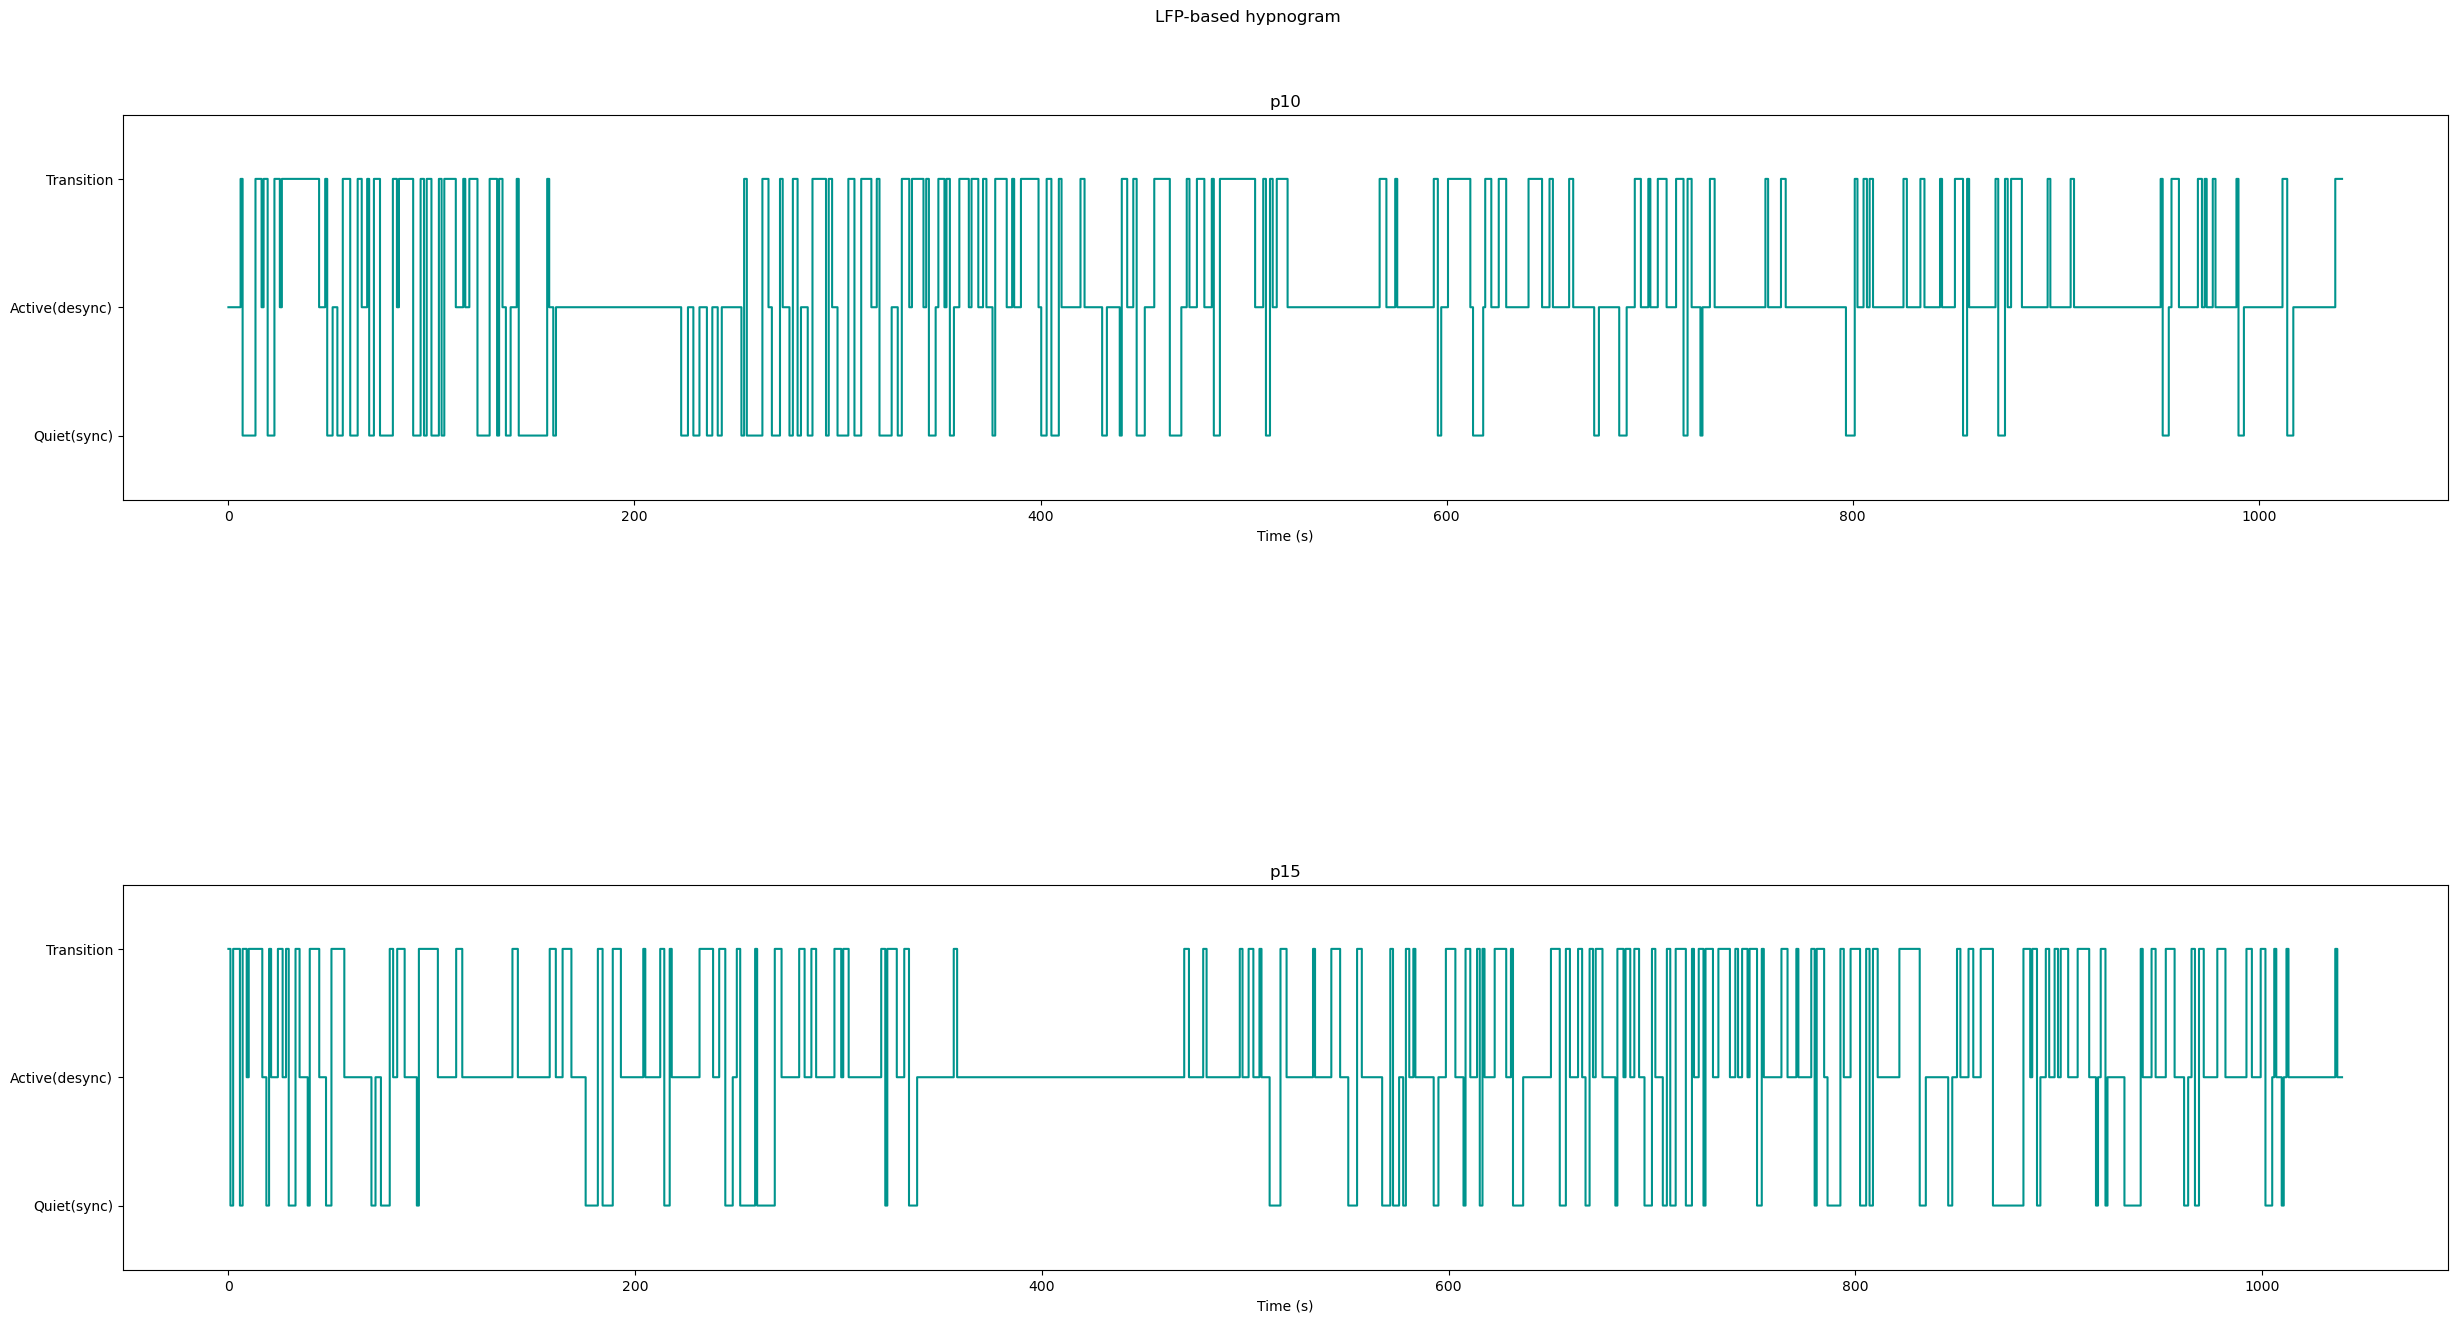

In [10]:
# bandpowers = overall_metrics()
# theta_db, gamma_db, delta_db = bandpowers['theta_z'], bandpowers['gamma_z'], bandpowers['delta_z']
# broadband_db = bandpowers['broadband_z']
from lfp.lfpFunctions import *

def plot_hypnogram_thresholded(rec_paths, lfp_channels=[1, 0],
                             lfp_chan_titles= ['(Channel 1 (local V1))', '(Channel 2)'],
                               color="#0B5E24", lfp_fs=1250, ylab='Power dB', suptitle='Gamma Power'):
    fig, axs = plt.subplots(len(rec_paths), len(lfp_channels), figsize=(30,15))
    states_dict = {}
    rec_idx = 0
    for rec in rec_paths:
        day = os.path.basename(rec)
        rec_lfp = os.path.join(rec, f'{day}.lfp')
        lfp = load_lfp(rec_lfp)
        lfp_chan_idx = 0
        for lfp_chan_idx, lfp_chan in enumerate(lfp_channels):
            freqs, times, power_db = compute_power_spect_db(lfp[lfp_chan], fs=lfp_fs)
            bandpowers = summarize_bands(spect_power_db=power_db, f=freqs)
            delta_db , theta_db, gamma_db, broadband_db = bandpowers['delta_z'], bandpowers['theta_z'], bandpowers['gamma_z'], bandpowers['broadband_z']
            tr = compute_linear_power_ratio(delta_db, theta_db)   # delta/theta
            tgr = compute_linear_power_ratio(theta_db, gamma_db)   # theta/gamma
            gdr = gamma_db - delta_db             # gamma-delta diff in dB (already useful)
            def smooth1d(x, win=9):
                x = np.asarray(x, float)
                if win <= 1:
                    return x
                k = np.ones(win) / win
                return np.convolve(x, k, mode="same")
            dtr = compute_linear_power_ratio(delta_db, theta_db) 
            dtr_log = np.log10(dtr + 1e-12)
            dtr_log = smooth1d(dtr_log, win=9)
            bb_s    = smooth1d(broadband_db, win=9)
            gdr_s   = smooth1d(gdr, win=9)
            hi_sync = np.nanpercentile(dtr_log, 75)   # high delta/theta = synchronized
            lo_sync = np.nanpercentile(dtr_log, 35)   # low delta/theta = desynchronized

            hi_bb   = np.nanpercentile(bb_s, 70)      # high broadband often = arousal/movement/artifact
            # states: 0=Quiet/sync, 1=Active/desync, 2=Transition/other
            state = np.full_like(dtr_log, 2, dtype=int)

            # Quiet / synchronized: high delta/theta and relatively low broadband
            state[(dtr_log >= hi_sync) & (bb_s < hi_bb)] = 0

            # Active / desynchronized: low delta/theta OR broadband high
            state[(dtr_log <= lo_sync) | (bb_s >= hi_bb)] = 1

            state_clean = enforce_min_state_duration(state, minimum_duration=3)
            if len(lfp_channels) == 1:
                ax_to_plot = axs[rec_idx]
            else:
                ax_to_plot = axs[rec_idx, lfp_chan_idx]
        states_dict[day] = state_clean
        ax_to_plot.step(np.arange(len(state_clean)) / 3, state_clean, where="post", color="#00948D")
        ax_to_plot.set_yticks([0,1,2], ["Quiet(sync)", "Active(desync)", "Transition"])
        ax_to_plot.set_ylim(-0.5, 2.5)
        ax_to_plot.set_xlabel("Time (s)")
        ax_to_plot.set_title(f"{day}")
        rec_idx += 1
    plt.suptitle("LFP-based hypnogram", y=0.95)
    plt.subplots_adjust(hspace=1)
    plt.show()
    return states_dict


states_dict = plot_hypnogram_thresholded(recs_10_15, lfp_channels=[1])

In [ ]:
dataclass_p9 = dataclasses_dict['p17']
dataclass_p9.scope_times
motion_raw = state_df['motion']
motion_times = state_df['time']
motion = motion_to_2p_bins(frame_times, motion_raw, motion_times=motion_times)

array([  7.81445,   7.8482 ,   7.88205, ..., 922.8168 , 922.8507 ,
       922.8846 ], shape=(26999,))